# Passer-classifier

The goal of this project is to create classifier that can separate individuals between two sparrow species: *Passer montanus* and *Passer domesticus*. I intend to use only male individuals here, but the code is extendable for female individuals also, but that might be less performant than the one with only male individuals.

I aim to do this project quick and dirty using fastai's awesome library that runs on top of PyTorch. I love the philosophy behind the fastai library and I intend to use it in the future as well. Let's start by importing the main components from fastai that we need for creating the classifier.

Oh, btw, my approach here is to use CNN based on popular CNN architectures such as ResNet

1. TOC
{:toc}

In [1]:
from fastai.vision import *

Before I proceed, I'd like to check what kind of device I'm working with before training the model. As of writing this, I'm using my own PC with RTX 2080 GPU, as we should see here

In [2]:
import torch
torch.cuda.get_device_name(0)

'GeForce RTX 2080'

# Download images for classifier

## Get a list of URLs

To start this process fire up the Google Image search and type in the search words you're after. In my case I typed this into search field:

`"passer montanus" -female`

Most of the search results look pretty ok to me, but don't worry, we'll come back to clean up the dataset a bit later on. As a side note, you can see maximum number of 700 pictures in search, so that is the upper limit for our dataset size for each label. I intend to work with a bit smaller dataset, let's say 400 images for each Google Image search



### Download into file

Now we run some Javascript code in browser which will save the URLs of all the images we want for our dataset. Fire up the developer tool in your browser and paste this code there:

`urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));`

Make sure that you disable your adblocker before running the above code. Running the code downloads the file to your downloads folder

### Create a directory and upload urls file into your machine

In [4]:
folder = 'passer-montanus'
file = 'passer_montanus.csv'

In [7]:
folder = 'passer-domesticus'
file = 'passer_domesticus.csv'

Then run this cell once per each category

In [8]:
path = Path('data/birds')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [9]:
path.ls()

[PosixPath('data/birds/models'),
 PosixPath('data/birds/passer-domesticus'),
 PosixPath('data/birds/passer_domesticus.csv'),
 PosixPath('data/birds/passer-montanus'),
 PosixPath('data/birds/passer_montanus.csv')]

## Download images

fast.ai has a function that downloads files from respective urls. We just have to specify the urls filename as well as the destination folder and this function will download all images that can be opened. If they have some problem in being opened, they will not be save

Run this line once for every category

In [10]:
classes = ['passer-montanus', 'passer-domesticus']

In [20]:
download_images(path/file, dest, max_pics=400)

Remove images that can't be opened:

In [21]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

## View data

In [11]:
np.random.seed(2020)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
                                 ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Take a look at the classes and pictures

In [12]:
data.classes

['passer-domesticus', 'passer-montanus']

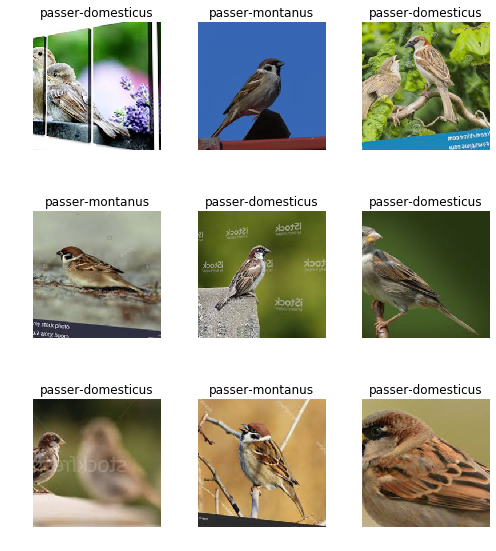

In [13]:
data.show_batch(rows=3, figsize=(7,8))

Here we see below:
- Class labels
- Number of labels
- Training set size
- Validation set size

In [14]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['passer-domesticus', 'passer-montanus'], 2, 512, 128)

# Train model

We use pretrained ResNet model and with fast.ai this is super simple and doesn't take that many lines to train the data. Note here, that we don't need to write CNN architecture because we are using pretrained ResNet model with architecture defined by that model. We can use different models than ResNet, but ResNet34 feels like a good starting point here. If our model over- or underfits significantly we can then think about different models

In [15]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [16]:
learn.fit_one_cycle(5)

Pretty promising results so far with couple of lines with code. At this moment based on those metrics we don't significantly over- or underfit and our model is doing ok (77%). Let's save our model with simple command:

In [17]:
learn.save('stage-1')

Now we make all layers available for training by unfreezing the layers making it possible to update weights to all layers

In [18]:
learn.unfreeze()

Find the best learning rate for underlying data:

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


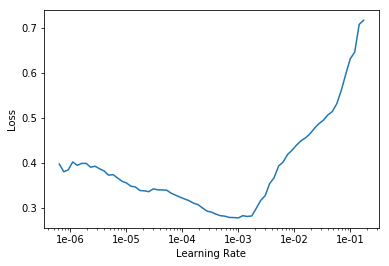

In [20]:
learn.recorder.plot()

On the learning rate finder, we are looking for the strongest downward slope that's kind of sticking around for quite a while. This is something you just need a practice on - practice makes perfect!

In [21]:
learn.fit_one_cycle(6, max_lr=slice(3e-4, 3e-3))

We gained a bit better classifier here as our error_rate went down from 23% to around 11%. Slight improvement, but I'll take it anyway! Let's save this classifier

In [22]:
learn.save('stage-2')

## Interpretation

Let's plot simple confusion matrix to see how our model performed

In [23]:
learn.load('stage-2');

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

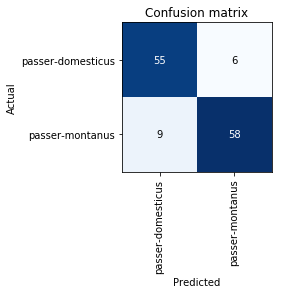

In [26]:
interp.plot_confusion_matrix()

Let's see some examples what labels our classifier puts on iamges

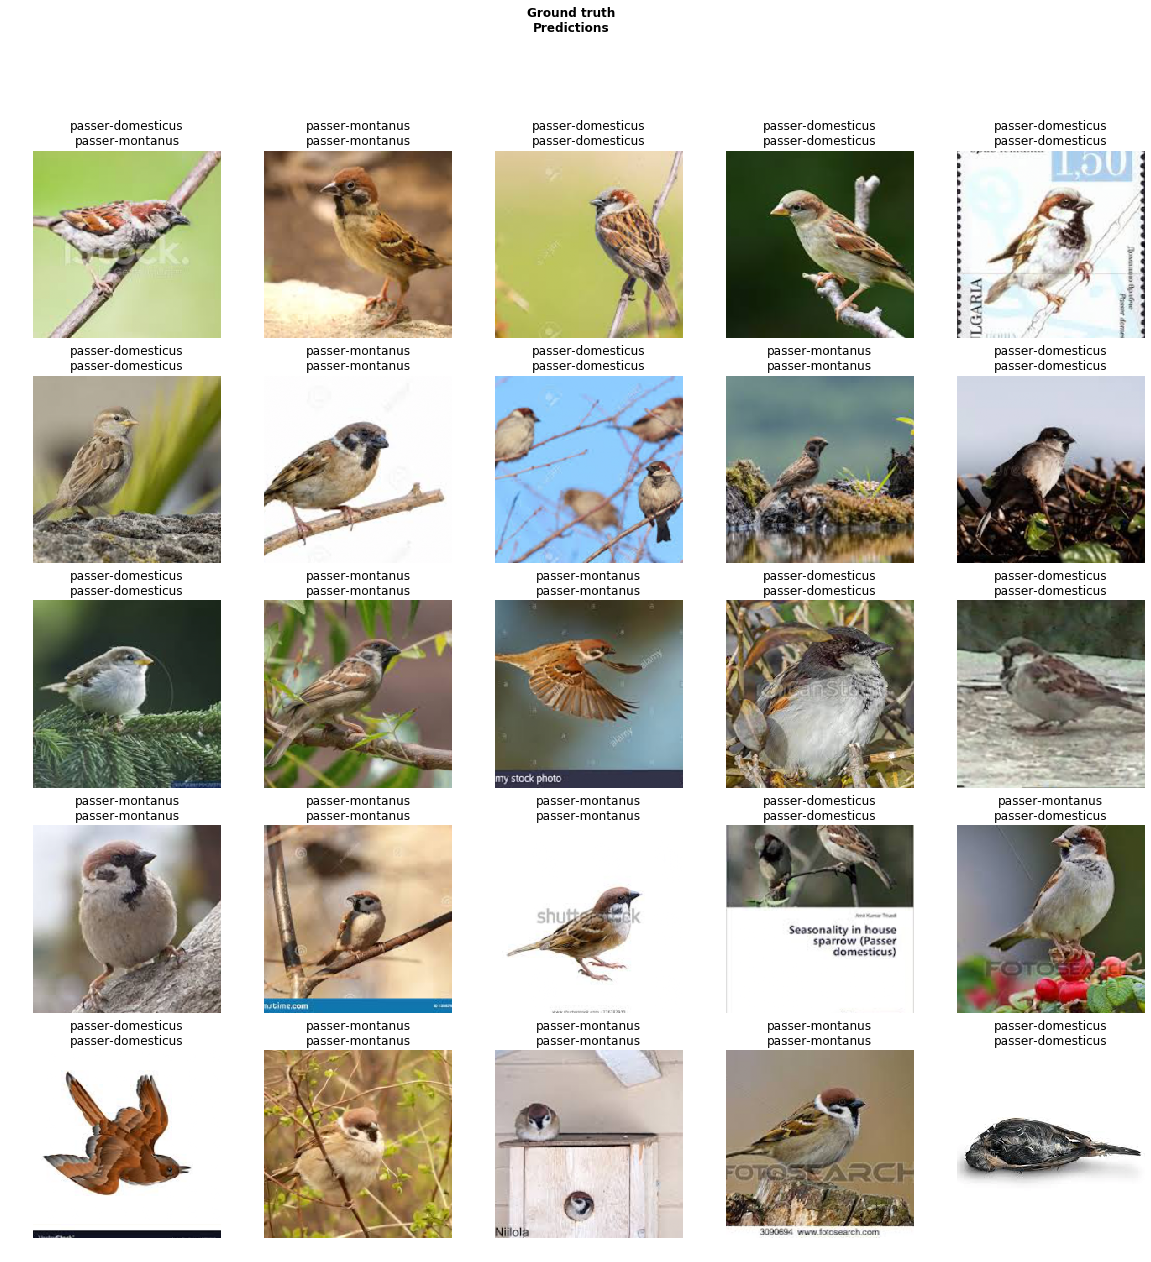

In [27]:
learn.show_results()

Based on these results seems like our Passer classifier is doing pretty well. One thing to note here that it seems to be able to classify female individuals of both species in this small sample I showed you above. But you can easily see that our dataset is still pretty corrupted as it contains lots of bad pictures of our Passer individuals. We aim to work with that in the next section

# Cleaning up

Some of our top losses might not be because of our classifier. Most of the problems with top losses come from poor pictures. We aim to remedy this here by pruning our dataset to be a bit better. One way to do that is to use `ImageCleaner` widget from `fastai.widgets` 

In [33]:
from fastai.widgets import *

One neat feature of `ImageClearner` widget is that it actually doesn't remove any pictures from folders, it just creates a new csv called `cleaned.csv` from where you can create new `ImageDataBunch` with the corrected labels

We want to perform the cleaning to the whole dataset, so we need to create new dataset without the split:

In [34]:
db = (ImageList.from_folder(path)
     .split_none()
     .label_from_folder()
     .transform(get_transforms(), size=224)
     .databunch())

Now we create new `cnn_learner` and load the model we saved after finding the optimal learning rate earlier. We can see the parameters of the model and examine them. We use this new classifier with all the images

In [35]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (640 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
passer-domesticus,passer-domesticus,passer-domesticus,passer-domesticus,passer-domesticus
Path: data/birds;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/birds;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64,

In [36]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [37]:
ImageCleaner(ds, idxs, path)

'No images to show :)'

{% include screenshot url="passer-classifier/image-cleaner.png" %}

You can see from above screenshot how the `ImageCleaner` looks like in action. We get a batch of pictures with top losses and we get to choose if we want to remove pictures that our models is going to see. This makes it easy to modify and improve our dataset on the fly. Remember that we don't remove these pictures, we just add modifications to `cleaned.csv` and read only the pictures in it (we don't include images we chose to delete in `clean.csv` file).

Once the `ImageCleaner` is done, we get notification: `'No images to show :)`

We can also remove duplicates from the dataste. In order to do this, we need to get the similar pictures using `.from_similars` and then we can run the `ImageCleaner` with `duplicates=True`. This works same way as before

In [38]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [39]:
ImageCleaner(ds, idxs, path, duplicates=True)

'No images to show :). 4 pairs were skipped since at least one of the images was deleted by the user.'

![](/images/passer-classifier/image-cleaner.png)

Whew, that was a lot of clicking. But now its done and I have a good feeling that our dataset is much better than before. Now the important thing to remember here, is that we have to recreate our `ImageDataBunch` from `cleaned.csv` so that our modifications don't go to waste. So let's do that here

In [40]:
np.random.seed(2020)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
                              ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Let's do some exploration on our improved dataset and compare the structure to our previous dataset without modifications:

In [41]:
data.classes

['passer-domesticus', 'passer-montanus']

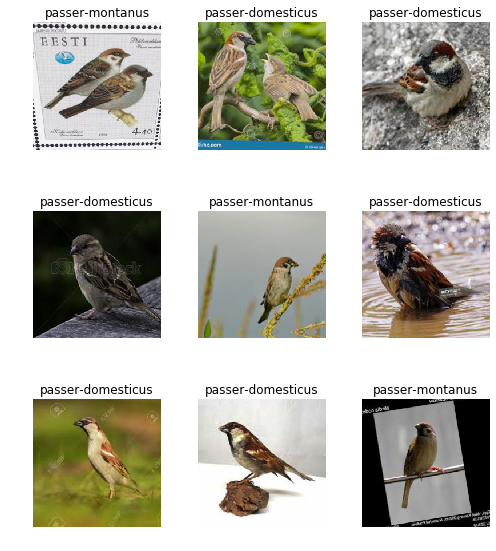

In [42]:
data.show_batch(rows=3, figsize=(7,8))

In [43]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['passer-domesticus', 'passer-montanus'], 2, 506, 126)

Comparison to our previous dataset (old, new):
- `data.classes` and `data.c`: exactly the same as they should be
- `len(data.train_ds)`: 512 vs. 506
- `len(data.valid_ds)`: 128 vs. 126

So we removed some or our pictures but not that many considering the total number of pictures. Let's see how this affects our model

In [44]:
learn_cleaned_set = cnn_learner(data, models.resnet34, metrics=error_rate)
learn_cleaned_set.load('stage-2');

In [45]:
learn_cleaned_set.fit_one_cycle(6, max_lr=slice(3e-4, 3e-3))

In [46]:
learn_cleaned_set.save('stage-3')

Looks good! We managed to our error rate down to less than 10% with 6 epochs. We might run a bit more epochs to see if our error_rate would go down even more and if our train_loss and valid_loss should be more similar. Let's try that:

In [47]:
learner = cnn_learner(data, models.resnet34, metrics=error_rate)
learner.load('stage-2');

In [48]:
learner.fit_one_cycle(10, max_lr=slice(3e-4, 3e-3))

Based on these results we can see that our model is kind of overfitting and we used excess number of epochs in the model above. We can tell that by seeeing that the valid_loss kind of bounces around as does the error_rate too. I think we are comfortable with our `stage-3` model here, so let's do some interpretation using that one:

In [49]:
learn_cleaned_set.load('stage-3');

In [50]:
interp = ClassificationInterpretation.from_learner(learn_cleaned_set)

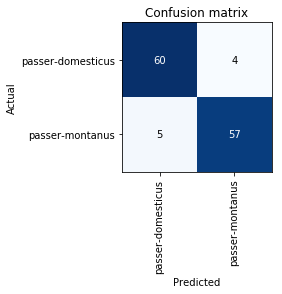

In [51]:
interp.plot_confusion_matrix()

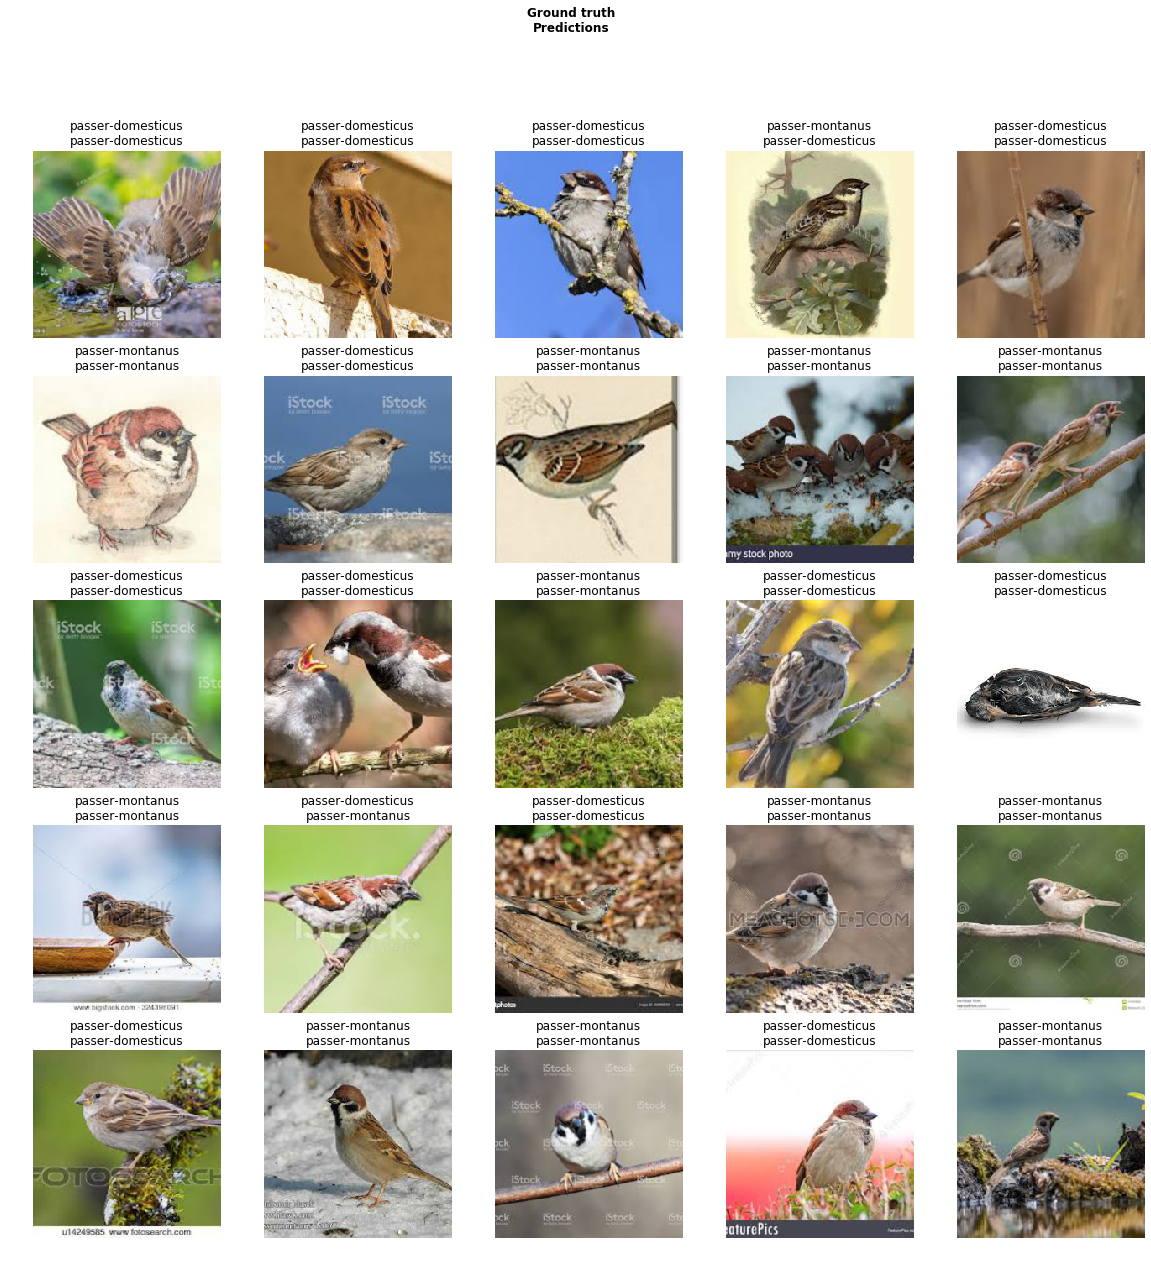

In [52]:
learn_cleaned_set.show_results()

Most of our predictions hit the spot here, but no model is perfect as they should not be. We can still see that our dataset isn't perfect as there is still at least one female picture in these pictures. This is the side effect when loading the images from Google Image search as it often contains wrong pictures or some mislabeled ones.

But overall, this was quite fast process to test out some CNN classifiers with my own created dataset. In the futrue I might do another CNN classifier, this time using labels from more than two classes (multi-class). Feel free to try this out and have fun while doing it!